<a href="https://colab.research.google.com/github/TheodoredaCunha/Homemade-GPT-Model/blob/main/GPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Loading and Cleaning the Dataset**

In [2]:
import string
import nltk.data
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.data import load
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('tagsets')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.


In [3]:
#getting all the filenames that contain the data
TOTAL_CHAPTERS  = 3
dataset = []
for i in range(1, TOTAL_CHAPTERS + 1):
  dataset.append("chapter{}.txt".format(i))

print(dataset)

['chapter1.txt', 'chapter2.txt', 'chapter3.txt']


In [4]:
#printing all possible POS tags
tagdict = load('help/tagsets/upenn_tagset.pickle')
all_tags = tagdict.keys()
print(all_tags)

dict_keys(['LS', 'TO', 'VBN', "''", 'WP', 'UH', 'VBG', 'JJ', 'VBZ', '--', 'VBP', 'NN', 'DT', 'PRP', ':', 'WP$', 'NNPS', 'PRP$', 'WDT', '(', ')', '.', ',', '``', '$', 'RB', 'RBR', 'RBS', 'VBD', 'IN', 'FW', 'RP', 'JJR', 'JJS', 'PDT', 'MD', 'VB', 'WRB', 'NNP', 'EX', 'NNS', 'SYM', 'CC', 'CD', 'POS'])


In [5]:
from os import setpgid

PATH = "drive/MyDrive/gpt/"
VOCAB_SET = set()
VOCAB_DICTIONARY = {}
ALL_CHAPTERS = []

def get_posttags(text):
  tokenized = word_tokenize(text)
  pos_tagged = nltk.pos_tag(text)
  tags = []
  for i in pos_tagged:
    tags.append(i[1])

  return tags

  return 
def cleanData(filepath): #lowercase all characters and removing punctuations
  with open(filepath) as f:
    full_chapter = f.read().lower()
    cleaned_chapter = full_chapter.translate (str.maketrans ('', '', string.punctuation)) #remove punctuations from every sentence
    cleaned_split_chapter = cleaned_chapter.split() #turn every sentence into a list of words
    chapter_vocab = set(cleaned_split_chapter) #update the set of unique words in this sentence
    ALL_CHAPTERS.append(cleaned_split_chapter) #append the cleaned chapter text to a single list
    VOCAB_SET.update(chapter_vocab) #update the set of unique words for all chapters in the data
    f.close() #close the file

 
def createVocabDictionary(): #fill out vocab_dictionary based on the vocab set
  vocab_list = list(VOCAB_SET)
  for count, word in enumerate(vocab_list): #assign a number to every word in the vocab list
    VOCAB_DICTIONARY[word] = count

'''
IMPLEMENTING THE FUNCTIONS:
'''
#opening and cleaning each chapter
for chapter in dataset:
  print(chapter)
  tags = cleanData(PATH + chapter)

#creating the vocabulary dictionary
createVocabDictionary()

#convert each letter in the chapters into their assigned numbers from the dictionary
for chapter in ALL_CHAPTERS:
  for i in range(len(chapter)):
    chapter[i] = VOCAB_DICTIONARY[chapter[i]]

print(ALL_CHAPTERS[0])

chapter1.txt
chapter2.txt
chapter3.txt
[52, 1854, 1676, 46, 1654, 746, 1892, 355, 2037, 1084, 546, 466, 1015, 1662, 617, 1084, 1188, 1865, 243, 1549, 688, 95, 617, 1084, 61, 1935, 1714, 1373, 1456, 466, 1680, 1246, 248, 1366, 816, 1930, 631, 1157, 617, 689, 1929, 2094, 579, 114, 594, 52, 46, 955, 61, 271, 1654, 488, 669, 1888, 325, 979, 1064, 1023, 1091, 955, 488, 113, 906, 74, 579, 1961, 1454, 36, 1823, 1091, 2153, 1971, 488, 688, 538, 523, 1676, 46, 955, 1658, 1854, 201, 1854, 1557, 1965, 699, 61, 601, 649, 1654, 36, 979, 269, 248, 688, 1317, 428, 614, 436, 830, 95, 1654, 1043, 1090, 2070, 403, 1256, 24, 1075, 1563, 61, 2048, 61, 1953, 1557, 488, 694, 60, 1888, 1060, 1854, 248, 1143, 734, 362, 955, 2057, 1383, 1262, 1377, 61, 1953, 1557, 1883, 617, 516, 417, 617, 554, 1557, 488, 425, 1854, 1143, 994, 102, 955, 1662, 1097, 142, 1607, 1300, 617, 1929, 1527, 617, 1135, 900, 1300, 883, 1884, 1896, 283, 299, 61, 2101, 1676, 72, 955, 1676, 1953, 2103, 417, 617, 1704, 760, 1987, 251, 720, 2

**Creating the GPT Model**

In [6]:
import torch
import torch.nn as nn
from torch.nn import functional as F

In [7]:
training = []
testing = []
sampling_rate = 0.1 #10% of the sentences from each chapter will be used as test data
for chapter in ALL_CHAPTERS:
  test_data_num = int(len(chapter)*0.1)
  training.append(chapter[test_data_num * -1:])
  testing.append(chapter[:test_data_num])  

for i in range(TOTAL_CHAPTERS):  
  training[i] = torch.tensor(training[i], dtype=torch.long)
  testing[i] = torch.tensor(testing[i], dtype=torch.long)

In [8]:
#chunking the data
context_length = 20
batch_size = 10
torch.manual_seed(1337)

def get_batches(data):
  ix = torch.randint(len(data) - context_length, (batch_size,))
  x = torch.stack([data[i:i+context_length] for i in ix])
  y = torch.stack([data[i + 1:i+context_length + 1] for i in ix])
  return x, y

x_1, y_1 = get_batches(training[0])
print(x_1)
print(y_1)



tensor([[  61,  155, 1654, 1078, 1563,   61, 1659, 1654,  746, 1892,  389,  150,
         1836, 1091, 1633, 1091,  642, 1563,  268,  495],
        [2009,  417,  683,  488,  942, 1563,  188, 1258, 1930,  527, 1680, 1896,
         1621, 1613,  715,  373, 1258, 1068, 1563,   61],
        [1258, 1930,  527, 1680, 1896, 1621, 1613,  715,  373, 1258, 1068, 1563,
           61, 2034,  428, 1539,   57,  403,   61, 1467],
        [2011,  795, 1300, 2121, 2099, 2112,  585, 2099,  981, 1283, 1836,  305,
          245,  807,  579, 2004,  342,  342,   93,  845],
        [ 942, 1563,  188, 1258, 1930,  527, 1680, 1896, 1621, 1613,  715,  373,
         1258, 1068, 1563,   61, 2034,  428, 1539,   57],
        [ 955, 1787, 2132,  732, 1091,  142, 1680,  587,  248,  488,  634, 1411,
         1090, 1174, 1676, 1953,  718,  428,  614, 1717],
        [ 729,   99, 1854, 1848, 1497,   61,  500, 1077,   61,  688, 1935,  703,
         1549,  142, 1456,  650,   81,  466,  977, 1836],
        [ 355, 2037,  979, 

In [17]:
#Creating the MultiHeaded Attention
n_embd =  64
block_size = 32
class AttentionHead(nn.Module):
  def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

  def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

In [10]:
torch.manual_seed(1337)

#Creating a Bigram Model
class BigramModel(nn.Module): #Bigram Model that is a child of PyTorch's Module Class
  def __init__(self, vocab_size):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, vocab_size) #lookup table

  def forward(self, input, target = None):
      logits = self.embedding(input) #make predictions --> ouputs a (B, T, C) tensor

      if target == None:
          loss = None
      else:
        #reshaping logits and target to match the required shape by pytorch
        B, T, C = logits.shape 
        logits = logits.view(B*T, C)
        target = target.view(B*T)

        loss = F.cross_entropy(logits, target) #calculate log-likelihood loss
      
      return logits, loss

  def generate(self, idx, max_new_tokens):
    # idx is (B, T) array of indices in the current context
    for i in range(max_new_tokens):
      # get the predictions
      logits, loss = self(idx)
      # focus only on the last time step
      logits = logits[:, -1, :] # becomes (B, C) ; takes the last element in the T dimension
      # apply softmax to get probabilities
      probs = F.softmax(logits, dim=-1) # (B, C)
      # sample from the distribution
      idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
      # append sampled index to the running sequence
      idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
    return idx

vocab_size = len(VOCAB_SET)
print("vocab size: {}".format(vocab_size))
m = BigramModel(vocab_size)
logits, loss = m(x_1, y_1)
print(logits.shape)
print(loss)


'''
Expected loss: -ln(1/vocab_size) = -ln(1/2158) = 7.67693714582

But before training, the loss should obviously be higher
'''

vocab size: 2158
torch.Size([200, 2158])
tensor(8.0750, grad_fn=<NllLossBackward0>)


'\nExpected loss: -ln(1/vocab_size) = -ln(1/2158) = 7.67693714582\n\nBut before training, the loss should obviously be higher\n'

In [11]:
def decode(encoded): #function to map id to word in the vocab dictionary
  VOCAB_DICTIONARY_INV = {v: k for k, v in VOCAB_DICTIONARY.items()} #inverting vocabulary dictionary
  output = ""
  for i in encoded:
    output += VOCAB_DICTIONARY_INV[i] + " "

  return output

encoded_ouput = m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()
output = decode(encoded_ouput)
print(output)

him cheer pop noticing snapped suspension scotch arm stupid parties woman relation contrary nodded scruffs escaping moaned reach milk town hammered air murmured boat black realized tufty rooted duddydums mirror word mail stomach once examined leap kiss cupboard stumbled wrestled privately still shredded gotten nails egg somebody tomatoes himself sharp smiling wear sunrise course peoples passersby banged “ pictures miserable large almost giant pain happily paper sky dabbed racing shooting yet boys severelooking snapped appeared keep seaweed snorted trodden father emerald reason things seem one fierce glowed sitting there aside dining own neck different fall nothing tidy stupid thunder shuddered wildly 


In [12]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3) #Using the Adam Optimizer
batch_size = 32
loss_history = []
for steps in range(500): # increase number of steps for good results... 
    
    # sample a batch of data
    xb, yb = get_batches(training[0])

    # evaluate the loss
    logits, loss = m(xb, yb)
    loss_history.append(loss.item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())

7.466775417327881


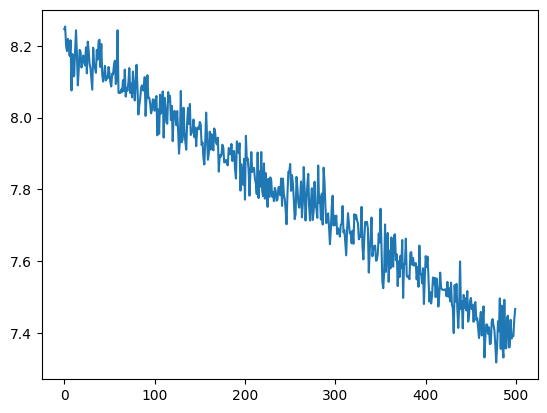

In [13]:
import matplotlib.pyplot as plt
plt.plot(loss_history)

In [14]:
input = torch.ones((1, 1), dtype=torch.long)
input = input * 11
print(input)

tensor([[11]])


In [15]:
encoded_ouput = m.generate(idx = input, max_new_tokens=10)[0].tolist()
output = decode(encoded_ouput)
print(output)

fun hissing storm normally grown belong affect tasted opposite hide dark 
